In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import random
from IPython.display import display
from ipywidgets import interact, FloatSlider, IntSlider


# Lotka-Volterra Models: Deterministic vs Stochastic Approaches

In this notebook, we compare three implementations of the classic Lotka-Volterra predator-prey model:

1. **Deterministic model**: this is the standard model using ordinary differential equations (ODEs)
2. **Stochastic differential equation (SDE)**: noise is added to the deterministic model
3. **Stochastic Simulation Algorithm (SSA)**: continuous-time Markkov chain model, with discrete state spaces

In all three cases, the aim is to simulate the dynamics of a predator-prey system, where:
- The prey population grows exponentially in the absence of predators, it declines due to predation at a rate proportional to the predator and prey populations
- The predator population grows at a rate proportional to the prey population, and declines due to natural death at a constant rate

# 1. Deterministic Lotka-Volterra Model 

## Model Equations

Lotka-Volterra equations:
$$
\begin{aligned}
dx = (\alpha x - \beta xy) dt\\
dy = (\delta xy - \gamma y) dt
\end{aligned}
$$


Where:

- $ x $ is the number of prey  
- $ y $ is the number of predators  
- $ \alpha$ is the growth rate of prey in the absence of predators
- $ \beta$ is the rate of predation
- $ \delta$ is the growth rate of predators per prey eaten
- $ \gamma$ is the natural death rate of predators

We will simulate this model using Euler's method, for simplicity and direct comparison with the Euler-Maruyama method used in the SDE model.

In [2]:
def simulate_lv(alpha, beta, delta, gamma, x0, y0, T, dt):
    t = np.arange(0, T, dt) # time vector
    x = [x0]
    y = [y0] # initial populations of prey and predators

    for i in range(1, len(t)):
        dx = alpha * x[i-1] - beta * x[i-1] * y[i-1] # Prey growth
        dy = delta * x[i-1] * y[i-1] - gamma * y[i-1] # Predator growth
        
        x_next = x[i-1] + dx * dt  # solving the ODE using Euler's method 
        y_next = y[i-1] + dy * dt
        
        x.append(max(x_next, 0))
        y.append(max(y_next, 0))
    
    return np.array(t), np.array(x), np.array(y) 

def plot_lv_dynamics(t, x, y): 
    plt.figure(figsize=(12, 4))
    plt.plot(t, x, label='Prey (x)', color='blue')
    plt.plot(t, y, label='Predator (y)', color='red')
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.title('Deterministic Lotka-Volterra Dynamics')
    plt.legend()
    plt.grid(True)
    plt.show()


# since we want to use the interact function, we define the run function for simulation and plot 
def run_lv(alpha, beta, delta, gamma, x0, y0, T, dt):
    t, x, y = simulate_lv(alpha, beta, delta, gamma, x0, y0, T, dt)
    plot_lv_dynamics(t, x, y)

# here is an interactive plot for everything, we can study the behaviour of the model by changing the parameters 
# we can also change the population size, which can be usefull to study the behaviour based on it, because in the futur we will like to have it fixed. 
output_lv = interact(
    run_lv,
    alpha=FloatSlider(min=0.0, max=2.0, step=0.05, value=1.0, description='α (Prey growth)'),
    beta=FloatSlider(min=0.01, max=1.0, step=0.01, value=0.1, description='β (Predation rate)'),
    delta=FloatSlider(min=0.005, max=0.1, step=0.005, value=0.02, description='δ (Pred. reproduction)'),
    gamma=FloatSlider(min=0.1, max=2.0, step=0.05, value=0.5, description='γ (Pred. death)'),
    x0=IntSlider(min=10, max=200, step=10, value=100, description='Initial Prey'),
    y0=IntSlider(min=5, max=100, step=5, value=20, description='Initial Predator'),
    T=IntSlider(min=10, max=100, step=5, value=50, description='(Simulation Time)'),
    dt=FloatSlider(min=0.0005, max=0.01, step=0.0005, value=0.001, description='(Timestep)')
)

display(output_lv)

interactive(children=(FloatSlider(value=1.0, description='α (Prey growth)', max=2.0, step=0.05), FloatSlider(v…

<function __main__.run_lv(alpha, beta, delta, gamma, x0, y0, T, dt)>

In [ ]:
# # Parameters
# alpha = 1.0   
# beta = 0.1   
# delta = 0.075 
# gamma = 1.5

# # Initial conditions
# x0 = 40
# y0 = 9
# T = 50
# dt = 0.01
# t = np.arange(0, T, dt)

# 2. Stochastic Lotka-Volterra Model (continuous case)

This method introduces continuous noise into the ODEs. It captures environmental randomness.


To account for such randomness, we introduce **stochasticity** into the model using **stochastic differential equations (SDEs)**. This leads to the **stochastic Lotka–Volterra (SLV) model**, which captures more realistic population dynamics under uncertain biological conditions.

## Mathematical Formulation

The stochastic model can be written as:

$$
\begin{aligned}
dx &= [\alpha x - \beta xy]\,dt + \sigma_1 x\,dB_1 \\
dy &= [\delta xy - \gamma y]\,dt + \sigma_2 y\,dB_2
\end{aligned}
$$

Where : 

- $ x $ and $ y $ are the number of prey and predators respectively, like in the deterministic model.
- $\alpha, \beta , \gamma , \delta$ are the same as the deterministic model. 
- $ \sigma_1, \sigma_2 $ are the intensities of environmental noise for prey and predators respectively.
- $ dB_1, dB_2$ are independent brownian increments

This model provides a more realistic depiction of population dynamics, allowing us to study phenomena such as extinction risk, persistence under noise, and long-term variability.

We will simulate this model using the Euler-Maruyama method.

# 3. Stochastic Lotka-Volterra Model (discrete case)

This approach models discrete birth, death, and interaction events. It's ideal for small populations: unlike the ODE and SDE models, which are continuous in time and space, this model is discrete in the state space (the number of individuals), but continuous in time.

## Mathematical Formulation

We model the predator-prey interactions as a continuous-time Markov chain with discrete state space. The state of the system is represented by the pair $(x,y)$, and the transitions between states are governed by the following reactions:

   $$
   \begin{aligned}
   \text{Prey reproduction:} & \quad x \xrightarrow{\alpha} x + 1 \\
   \text{Predation:} & \quad (x,y) \xrightarrow{\beta} (x -1, y+1) \\
   \text{Predator death:} & \quad y \xrightarrow{\gamma} y -1
   \end{aligned}
   $$

Where:
- $x$ and $y$ are the number of prey and predators respectively, like in the previous models.
- $\alpha$ is the rate of prey reproduction
- $\beta$ is the rate of predation
- $\gamma$ is the rate of predator death

In this model, we can observe the behaviour we can expect from the model. 

The choice of an interactive graph allows us to have a good overview of the influence of each parameters. But, if we choose 4 parameters that are "classical" for a model, we can have the general behaviour of the model, not having some parameters at the extreme. 
If we choose : 
$ \alpha = 1.00 $
$ \beta = 0.10 $
$ \gamma = 1.50 $
$ \delta = 0.07$.

## Predator-Prey dynamics with standard parameters

In this model, we can observe the deterministic predator-prey dynamics predicted by the Lotka–Volterra equations. 
Using an interactive graph helps us visualize how each parameter influences the system. However, by choosing a standard set of parameters — (not too extreme) we can capture the general behavior of the model without introducing unusual effects.

For example, using the following commonly used values:

- $ \alpha = 1.00 $  
- $ \beta = 0.10 $ 
- $ \gamma = 1.50 $ 
- $ \delta = 0.07 $ 

we obtain a "typical" simulation of predator-prey interactions.


# SDE PART 

In [5]:
def simulate_lv_sde(alpha, beta, delta, gamma, sigma1, sigma2, x0, y0, T, dt, seed=None):
    if seed is not None:
        np.random.seed(seed)

    t = np.arange(0, T, dt)
    x = np.zeros(len(t))
    y = np.zeros(len(t))
    x[0], y[0] = x0, y0

    for n in range(1, len(t)):
        z_n = np.random.randn()
        w_n = np.random.randn()

        x_prev, y_prev = x[n-1], y[n-1]
        dx = (alpha * x_prev - beta * x_prev * y_prev) * dt + sigma1 * x_prev * np.sqrt(dt) * z_n
        dy = (delta * x_prev * y_prev - gamma * y_prev) * dt + sigma2 * y_prev * np.sqrt(dt) * w_n

        x[n] = max(x_prev + dx, 0)
        y[n] = max(y_prev + dy, 0)

    return t, x, y

# Plotting function
def plot_lv_sde(t, x, y):
    # Time series
    plt.figure(figsize=(12, 4))
    plt.plot(t, x, label='Prey (x)', color='blue')
    plt.plot(t, y, label='Predator (y)', color='red')
    plt.xlabel("Time")
    plt.ylabel("Population")
    plt.title("Stochastic Lotka–Volterra Dynamics (Euler–Maruyama)")
    plt.legend()
    plt.grid(True)
    plt.show()


# Wrapper function for interactive simulation
def run_lv_sde(alpha, beta, delta, gamma, sigma1, sigma2, x0, y0, T, dt):
    t, x, y = simulate_lv_sde(alpha, beta, delta, gamma, sigma1, sigma2, x0, y0, T, dt, seed=1)
    plot_lv_sde(t, x, y)

# Create interactive UI
interact(
    run_lv_sde,
    alpha=FloatSlider(min=0.0, max=2.0, step=0.05, value=1.0, description='α (Prey growth)'),
    beta=FloatSlider(min=0.01, max=1.0, step=0.01, value=0.1, description='β (Predation rate)'),
    delta=FloatSlider(min=0.005, max=0.1, step=0.005, value=0.02, description='δ (Pred. reproduction)'),
    gamma=FloatSlider(min=0.1, max=2.0, step=0.05, value=0.5, description='γ (Pred. death)'),
    sigma1=FloatSlider(min=0.0, max=1.0, step=0.05, value=0.2, description='σ₁ (Prey noise)'),
    sigma2=FloatSlider(min=0.0, max=1.0, step=0.05, value=0.2, description='σ₂ (Pred. noise)'),
    x0=IntSlider(min=10, max=200, step=10, value=100, description='Initial Prey'),
    y0=IntSlider(min=5, max=100, step=5, value=20, description='Initial Predator'),
    T=IntSlider(min=10, max=100, step=5, value=50, description='T (Simulation Time)'),
    dt=FloatSlider(min=0.0005, max=0.01, step=0.0005, value=0.001, description='dt (Timestep)')
);


interactive(children=(FloatSlider(value=1.0, description='α (Prey growth)', max=2.0, step=0.05), FloatSlider(v…

### Interpretation of the Stochastic Lotka–Volterra simulation

The general behavior of the system — governed by the parameters $\alpha$, $\beta$, $\gamma$, and $\delta$ — remains consistent with the deterministic version.

The main difference lies in the presence of stochastic noise: the trajectories are no longer smooth, but exhibit random fluctuations around the deterministic paths. This variability is directly influenced by the noise intensities $\sigma_1$ and $\sigma_2$, which control the amplitude of the stochastic perturbations on the prey and predator populations, respectively.

As expected:
- Lower values of $\sigma_1$ and $\sigma_2$ lead to dynamics that ressembles the deterministic model.
- Higher values introduce more pronounced deviations, increasing the irregularity of the cycles and the unpredictability of population levels.

Overall, the simulation confirms the theoretical expectations: the stochastic model behaves like the deterministic one, but with noise whose magnitude depends directly on the chosen noise parameters.



# Part 3: Stochastic Lotka-Volterra, using Gillespie algorithm

In [ ]:
sigma1 = 0.2
sigma2 = 0.2  

In [6]:
# Stochastic simulation using Gillespie algorithm
def simulate_lv_reactions(c1, c2, c3, x0, y0, T, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Initial time and populations
    t = [0.0]
    x = [x0]
    y = [y0]

    while t[-1] < T and x[-1] > 0 and y[-1] > 0: # Continue while either time is ended, either one of the population is 0
        x_curr, y_curr = x[-1], y[-1]

        # Propensities (event rates)
        a1 = c1 * x_curr                    # Prey reproduction
        a2 = c2 * x_curr * y_curr           # Predation
        a3 = c3 * y_curr                    # Predator death
        a_total = a1 + a2 + a3

        if a_total == 0:
            break  # no more reactions possible

        # Time to next event
        dt = np.random.exponential(1.0 / a_total)
        t.append(t[-1] + dt)

        # Determine which event occurs
        r = np.random.rand() * a_total
        if r < a1:
            x.append(x_curr + 1)    # prey reproduces
            y.append(y_curr)
        elif r < a1 + a2:
            x.append(x_curr - 1)    # predation: prey dies
            y.append(y_curr + 1)    # predator reproduces
        else:
            x.append(x_curr)        # predator dies
            y.append(y_curr - 1)

    return np.array(t), np.array(x), np.array(y)


In [7]:
def plot_lv_reactions(t, x, y):
    # Time series
    plt.figure(figsize=(12, 4))
    plt.step(t, x, where='post', label='Prey (x)', color='blue')
    plt.step(t, y, where='post', label='Predator (y)', color='red')
    plt.xlabel("Time")
    plt.ylabel("Population")
    plt.title("Stochastic Reaction Simulation (Gillespie Algorithm)")
    plt.legend()
    plt.grid(True)
    plt.show()


#### For this part we decide to fix the population size, this choice is motivated by the fact that we would like to observe the effect of each variables $c_1$, $c_2$ and $c_3$. 
#### By choosing a population size of 100 initial prey and 20 initial predators, we are putting ourself in natural settings that allows us to change the other parameters and have informations about their impact on the behaviour of the populations


#### As for the previous models, the interactive plot is made to give an overview of the models behaviour when changing parameters. 
#### The end time and initial populations are variables here, but only for an exploration purpose, for the rest of the simulations it will be fixed as:
- $T$ = 50 (end_time)
- $x_o$ = 100 (initial prey time)
- $y_0$ = 20 (initial predator time)


In [ ]:
def run_lv_reactions(c1, c2, c3, x0, y0, T):
    t, x, y = simulate_lv_reactions(c1, c2, c3, x0, y0, T, seed=1)
    plot_lv_reactions(t, x, y)
    

### Here, maybe it would be usefull to explain what is what... meaning of the parameters and the meaning of the choice of the models.
interact(
    run_lv_reactions,
    c1=FloatSlider(min=0.00, max=2.0, step=0.1, value=0.5, description='c₁ (Prey birth)'),
    c2=FloatSlider(min=0.0001, max=0.1, step=0.0005, value=0.001, description='c₂ (Predation)'), 
    c3=FloatSlider(min=0.01, max=1.0, step=0.01, value=0.5, description='c₃ (Pred. death)'),
    x0=IntSlider(min=10, max=200, step=10, value=100, description='Initial Prey'),
    y0=IntSlider(min=5, max=100, step=5, value=20, description='Initial Predator'),
    T=IntSlider(min=10, max=100, step=5, value=50, description='T (Simulation Time)')
)



interactive(children=(FloatSlider(value=0.5, description='c₁ (Prey birth)', max=2.0), FloatSlider(value=0.001,…

<function __main__.run_lv_reactions(c1, c2, c3, x0, y0, T)>

### In this Part we want to study the the probability of prey exctinction probability. 
This is done in order to understand the effect of each values on the others.\

In [9]:
def extinction_heatmap_c1_c2(c1_vals, c2_vals, c3=0.5, x0=100, y0=20, T=50, runs=50): # fix value of c3 
    Z = np.zeros((len(c1_vals), len(c2_vals)))
    for i, c1 in enumerate(c1_vals):
        for j, c2 in enumerate(c2_vals):
            ext = 0
            for _ in range(runs):
                _, x, _ = simulate_lv_reactions(c1=c1, c2=c2, c3=c3, x0=x0, y0=y0, T=T)
                if x[-1] == 0:
                    ext += 1
            Z[i, j] = ext / runs
    plt.figure(figsize=(8, 6))
    plt.imshow(Z, origin='lower', extent=[c2_vals[0], c2_vals[-1], c1_vals[0], c1_vals[-1]],
               aspect='auto', cmap='plasma')
    plt.colorbar(label='Prey Extinction Probability')
    plt.xlabel('c₂ (Predation rate)')
    plt.ylabel('c₁ (Prey birth rate)')
    plt.title('Prey Extinction: c₁ vs. c₂')
    plt.grid(False)
    plt.show()


We choose $c_1$ and $c_3$, this is an empirical choice. \
when running the code we also tryed it with $0.3, 0.4, 0.5, 0.6, 0.7$ and they re values that is truncating information about the prey instiction probability. 
The following fixed values have been chosen :
- $c_1$ = 0.5
- $c_3$ = 0.5 

Remark : These choice are depending on the choice of the other parameters. Meaning that if we decide to set the initial populations at 1000 for preys and 200 for predators, then the choice of the biological parameters will be different. But as we explained above, the populations, and time are fixed so we can observe the behaviour of the model. \
It could be the scope of another project but for this one we will focus on $c_1$, $c_2$, $c_3$, based on fix population and fix end time. 

In [10]:
def extinction_heatmap_c2_c3(c2_vals, c3_vals, c1=0.5, x0=100, y0=20, T=50, runs=50): # fix value of c1
    Z = np.zeros((len(c2_vals), len(c3_vals)))
    for i, c2 in enumerate(c2_vals):
        for j, c3 in enumerate(c3_vals):
            ext = 0
            for _ in range(runs):
                _, x, _ = simulate_lv_reactions(c1=c1, c2=c2, c3=c3, x0=x0, y0=y0, T=T)
                if x[-1] == 0:
                    ext += 1
            Z[i, j] = ext / runs
    plt.figure(figsize=(8, 6))
    plt.imshow(Z, origin='lower', extent=[c3_vals[0], c3_vals[-1], c2_vals[0], c2_vals[-1]],
               aspect='auto', cmap='plasma')
    plt.colorbar(label='Prey Extinction Probability')
    plt.xlabel('c₃ (Predator death rate)')
    plt.ylabel('c₂ (Predation rate)')
    plt.title('Prey Extinction: c₂ vs. c₃')
    plt.grid(False)
    plt.show()


The choice of c2 = 0.01 is motivated by empirical ........ 
From Rochefort university slides about the subject. Also other papers


In [11]:
def extinction_heatmap_c1_c3(c1_vals, c3_vals, c2=0.01, x0=100, y0=20, T=50, runs=50): # fix value of c2 
    Z = np.zeros((len(c1_vals), len(c3_vals)))
    for i, c1 in enumerate(c1_vals):
        for j, c3 in enumerate(c3_vals):
            ext = 0
            for _ in range(runs):
                _, x, _ = simulate_lv_reactions(c1=c1, c2=c2, c3=c3, x0=x0, y0=y0, T=T)
                if x[-1] == 0:
                    ext += 1
            Z[i, j] = ext / runs
    plt.figure(figsize=(8, 6))
    plt.imshow(Z, origin='lower', extent=[c3_vals[0], c3_vals[-1], c1_vals[0], c1_vals[-1]],
               aspect='auto', cmap='plasma')
    plt.colorbar(label='Prey Extinction Probability')
    plt.xlabel('c₃ (Predator death rate)')
    plt.ylabel('c₁ (Prey birth rate)')
    plt.title('Prey Extinction: c₁ vs. c₃')
    plt.grid(False)
    plt.show()



In [12]:
c1_vals = np.linspace(0.1, 1.0, 20)
c2_vals = np.linspace(0.001, 0.05, 20)
c3_vals = np.linspace(0.1, 1.0, 20)

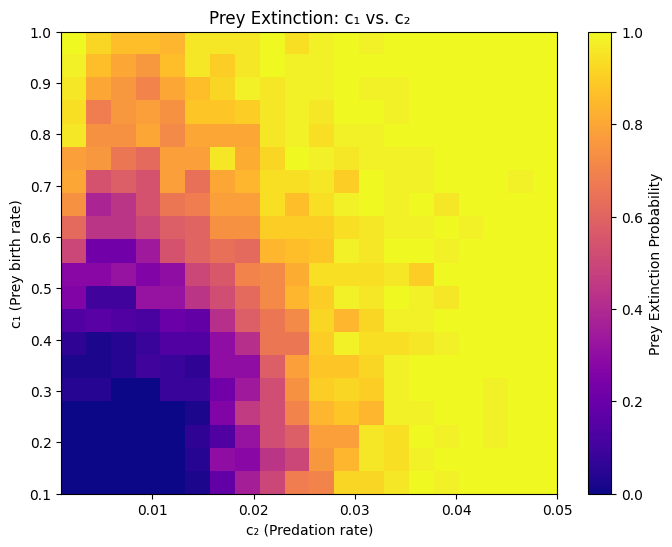

In [ ]:
# extinction_heatmap_c1_c2(c1_vals, c2_vals)


This heatmap shows how the probability of **prey extinction** changes based on:

- **$c_1$**: prey birth rate (y-axis)
- **$c_2$**: predation rate (x-axis)

#### Key Observations:

1. **High $c_2$**:
   - Even with a high prey birth rate, predation dominates. 
   - The prey population is almost always driven to extinction (yellow regions).

2. **Low $c_2$**:
   - If $c_1 $ is also low, prey reproduce too slowly and may still go extinct (purple-orange).
   - As $ c_1 $ increases, prey reproduction outpaces predation, and extinction becomes unlikely (dark blue).

3. **Transition zone**:
   - A diagonal boundary separates extinction from survival, it is not a strict separation but graduatly improves or 
   - This represents a tipping point where prey reproduction begins to counterbalance predation.

This map helps identify critical combinations of $ c_1 $ and $ c_2 $ where the survival of the prey population is at risk.


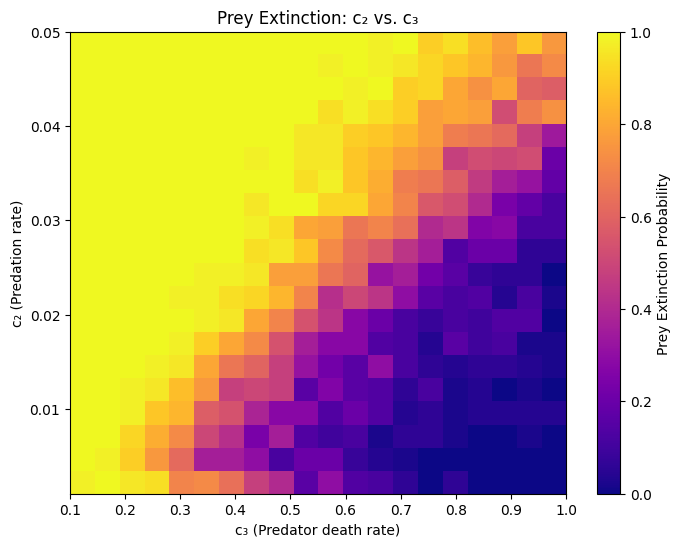

In [ ]:
# extinction_heatmap_c2_c3(c2_vals, c3_vals)


### Biological and Model Interpretation

This heatmap shows how the probability of **prey extinction** changes based on:

- **$c_2$**: predation rate (y-axis)
- **$c_3$**: predator death rate (x-axis)

#### Key Observations:

1. **Low predator death rate ($c_3$ low)**:
   - Predators survive longer, maintaining high predation pressure.
   - Even at low $c_2$, prey are likely to go extinct (yellow regions dominate).

2. **High predator death rate ($c_3$ high)**:
   - Predators die off quickly, reducing their impact.
   - Prey extinction becomes much less likely, especially when $c_2$ is also low (dark blue regions).

3. **threshold zone**:
   - A diagonal band shows where increasing $c_3$ begins to counteract the effect of $c_2$.
   - This boundary represents a shift from predator-dominated extinction to prey survival.

This plot highlights the **interplay between predation intensity and predator sustainability** in determining whether prey populations persist or collapse.


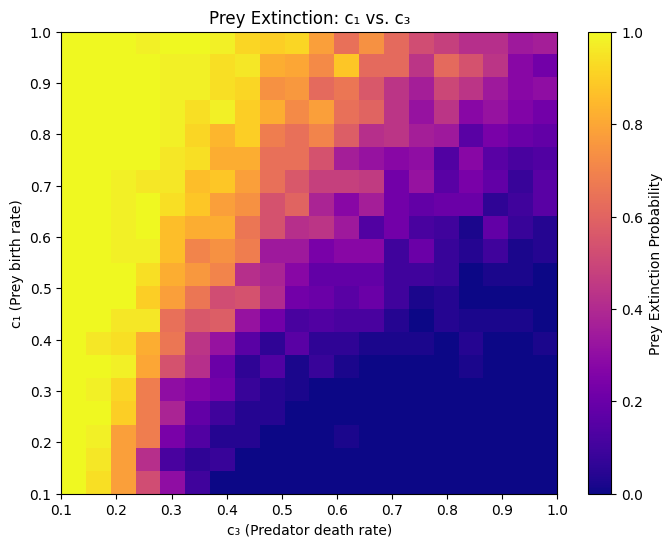

In [ ]:
# extinction_heatmap_c1_c3(c1_vals, c3_vals)

This heatmap shows how the probability of prey extinction changes based on:

- **$c_1$**: prey birth rate (y-axis)
- **$c_3$**: predator death rate (x-axis)

#### Key Observations:

1. **Low $c_3$**:
   - Predators survive longer and maintain strong pressure on prey.
   - Even high prey birth rates ($c_1$) cannot prevent extinction (yellow region dominates).

2. **High $c_3$**:
   - Predators die quickly, giving prey a better chance to survive.
   - Even low prey birth rates can be enough for survival (dark blue area).

3. **Transition zone**:
   - A vertical band marks the shift where increasing $c_3$ begins to counteract predation.
   - The tipping point depends on $c_1$: higher prey birth rate pushes the transition zone leftward.

This plot emphasizes the **combined effect of prey growth and predator decay** on prey survival, showing that **prey extinction becomes less likely when either reproduction is high or predators are short-lived**.


# OLD PART


## Gillespie Algorithm Overview

The Gillespie algorithm proceeds as follows:

# I would say that this part could be done later after having understood good the structure and the formalization of the algo
---

1. **Initialization**:
   - Set initial populations: $ N_{\text{prey}} $ and $ N_{\text{predator}} $.
   - Set initial time $ t = 0 $.

2. **Compute Propensities**:
   - $ a_1 = c_1 \times N_{\text{prey}} $
   - $ a_2 = c_2 \times N_{\text{prey}} \times N_{\text{predator}} $
   - $ a_3 = c_3 \times N_{\text{predator}} $
   - Total propensity: $ a_0 = a_1 + a_2 + a_3 $

3. **Determine Time to Next Reaction**:
   - Generate a random number $ r_1 $ uniformly distributed in (0,1).
   - Compute time increment: $ \tau = \frac{1}{a_0} \ln\left(\frac{1}{r_1}\right) $

4. **Select Next Reaction**:
   - Generate another random number $ r_2 $ uniformly distributed in (0,1).
   - Determine which reaction occurs by finding $ \mu $ such that:
     $ \sum_{j=1}^{\mu-1} a_j < r_2 \times a_0 \leq \sum_{j=1}^{\mu} a_j $

5. **Update System State**:
   - Update populations based on the selected reaction.
   - Advance time by $ \tau $.

6. **Iterate**:
   - Repeat steps 2–5 until the desired simulation time is reached.

This algorithm generates statistically correct trajectories of the stochastic system, allowing us to study the impact of randomness on predator-prey dynamics.

---

In the subsequent sections, we will implement this algorithm in Python to simulate and visualize the stochastic behavior of the Lotka–Volterra system.
